In [1]:
import lightcones.linalg as ll
from lightcones.linalg import kron
from lightcones.models import spinfull_fermions


U = 1
t = 0.05

num_iterations = 100

m = 100
l = 3 + 1

# iteration 0: preparatory

# left subsystem

f = spinfull_fermions(l)

In [2]:
H_hopp = sum([sum([- t * (f.a_dag[s][i] @ f.a[s][i - 1] + f.a_dag[s][i - 1] @ f.a[s][i]) for s in range(2)]) for i in range(l)])
H_S = H_hopp + sum([U * f.n[0][i] @ f.n[1][i] for i in range(l)])

In [3]:
H_S_ = kron(H_S, f.eye)

In [4]:
import scipy

In [5]:

H_S_2 = scipy.sparse.kron(H_S, f.eye, format = 'csc')

In [6]:
H_S_2

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 306944 stored elements and shape (65536, 65536)>

In [7]:
a_S = f.a[:][-1]
a_S_dag = f.a_dag[:][-1]

In [9]:
a_S

[<Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2048 stored elements and shape (4096, 4096)>]

In [8]:
a_S_ = kron(a_S, f.eye)

In [10]:
a_S_dag_ = kron(a_S_dag, f.eye)

In [11]:
H_E_ = kron(f.eye, H_S)

In [1]:
import numpy as np
import scipy
import lightcones.linalg as ll
from lightcones.linalg import kron
from lightcones.models import spinfull_fermions
import lightcones.space as sp
import math

U = 1
t = 0.05

num_iterations = 20

m = 10
l = 3 + 1

E_GND_convergence = []

# iteration 0: preparatory

# left subsystem
# we use [] for list of modes
#        {} for list of states 
# f = [: 3] * [1]

f = spinfull_fermions(l)

H_hopp = sum([sum([- t * (f.a_dag[s][i] @ f.a[s][i - 1] + f.a_dag[s][i - 1] @ f.a[s][i]) for s in range(2)]) for i in range(l)])
H_S = H_hopp + sum([U * f.n[0][i] @ f.n[1][i] for i in range(l)])

# underscore is for
# [: 3] * [1] * [: 3] * [1]
H_S_ = kron(H_S, f.eye)

# for [: 3] * [1]
a_S = f.a[:][-1]
a_S_dag = f.a_dag[:][-1]

# for [: 3] * [1]
a_S_ = kron(a_S, f.eye)
a_S_dag_ = kron(a_S_dag, f.eye)

# right subsystem

# fermion Hamiltonian is always even
H_E_ = kron(f.eye, H_S)

# a and a_dag are odd operators
a_E_ = kron(f.parity, a_S)
a_E_dag_ = kron(f.parity, a_S_dag)

# joint system Hamiltonian
H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])

# initial lanczos wavefunction for
# half filled case:
psi0 = np.zeros(f.dimension**2, dtype = complex)
psi0[0] = 1.0
for i in range(l):
    # populate left part
    psi0 = (kron(f.a_dag[0][i], f.eye) + kron(f.a_dag[1][i], f.eye)) @ psi0 / math.sqrt(2.0)
    # popular right part
    psi0 = (kron(f.parity, f.a_dag[0][i]) + kron(f.parity, f.a_dag[1][i])) @ psi0 / math.sqrt(2.0)

print("psi0 norm:")
print(np.vdot(psi0, psi0))

# total occupation of left subsystem:
N_left = sum([sum([f.a_dag[s][i] @ f.a[s][i] for s in range(2)]) for i in range(l)])
N_left_ = kron(N_left, f.eye)

print("psi0 left part occupation:")
print(np.vdot(psi0, N_left_ @ psi0))

# now start regular iterations

dimension_L = f.dimension
parity_L = f.parity

for i in range(num_iterations):

    # find ground state
    # for [: 3] * [1] * [: 3] * [1]
    E_GND, Psi_GND = ll.lancz_gnd_state(psi0, H_SE, 100)
    
    E_GND_convergence.append(E_GND)
    
    print("E_GND = ", E_GND)
    
    print("Psi_GND norm:")
    print(np.vdot(Psi_GND, Psi_GND))
    
    # partial trace
    bp = sp.bipartite(dimension_L, dimension_L)
    # for [: 3] * [1]
    rho = bp.trace_out_R(Psi_GND)
    
    # find eigenvalues sorted in descending order
    pi, T = ll.find_eigs_descending(rho)
    
    print("probability norm:")
    print(sum(pi))
    
    print("Schmidt components:")
    print(pi[:m])
    
    # keep only m largest eigenstates
    # columns are eigenstates
    T = scipy.sparse.csc_matrix(T[:, : m])

    # switch to the frame of revelant eigenstates
    # for {: m}
    T_dag = scipy.sparse.csc_matrix(T.conj().T)
    
    N_left_T = T_dag @ N_left @ T
    
    # for numerical stability:
    # N_left_T has natural numbers as eigenvalues
    N_left_T = N_left_T.rint()
    
    print("Population of Schmidt components:")
    left_N = N_left_T.diagonal().real
    print(left_N)
    
    # we compare population of left subsystem with l + i
    # since we start from l signly occupied sites, and add one electron
    # at each iteration (+ i electrons after i iterations) 
    #assert math.isclose(left_N[0], l + i, rel_tol=1e-7, abs_tol=1e-7), \
    #    "The most important Schmidt component is not at half filling."
    
    H_T = T_dag @ H_S @ T

    # boundary operators also get renormalized
    # for {: m}
    a_T = [T_dag @ a_S[s] @ T for s in range(2)]
    a_T_dag = [T_dag @ a_S_dag[s] @ T for s in range(2)]

    # new parity operator
    # for {: m}
    parity_T = T_dag @ parity_L @ T
    
    # for numerical stability:
    # parity_T has integers as eigenvalues
    parity_T = parity_T.rint()
    
    eye_T = ll.eye(m)
    
    # add new site
    g = spinfull_fermions(1)
    
    # new boundary operators
    # for {: m} * [1]
    
    # a and a_dag are odd operators
    a_S = kron(parity_T, [g.a[s][0] for s in range(2)])
    a_S_dag = kron(parity_T, [g.a_dag[s][0] for s in range(2)])
    
    a_T_ = kron(a_T, g.eye)
    a_T_dag_ = kron(a_T_dag, g.eye)
    
    # n is even operator
    n_ = kron(eye_T, [g.n[s][0] for s in range(2)])
    
    # 
    H_T_ = kron(H_T, g.eye)
    
    #
    H_S = H_T_ - t * sum([a_S_dag[s] @ a_T_[s] + a_T_dag_[s] @ a_S[s] for s in range(2)]) + U * n_[0] @ n_[1]
    
    eye_T_ = kron(eye_T, g.eye)
    
    # left subsystem
    # for {: m} * [1] * {: m} * [1]
    
    H_S_ = kron(H_S, eye_T_)
    
    a_S_ = kron(a_S, eye_T_)
    a_S_dag_ = kron(a_S_dag, eye_T_)

    # right subsystem
    # for {: m} * [1] * {: m} * [1]

    parity_T_ = kron(parity_T, g.parity)
    
    # fermion Hamiltonian is always even
    H_E_ = kron(eye_T_, H_S)

    # a and a_dag are odd operators
    a_E_ = kron(parity_T_, a_S)
    a_E_dag_ = kron(parity_T_, a_S_dag)
    
    # joint system Hamiltonian
    # for {: m} * [1] * {: m} * [1]

    H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])
    
    # update N_left operator
    # add new site
    N_left_ = kron(N_left_T, g.eye) + sum([kron(eye_T, g.n[i][0]) for i in range(2)])
    # embed into left-right system 
    # {: m} * [1] * {: m} * [1]
    #N_left = kron(N_left_, eye_T_)
    N_left = N_left_
    
    # update parity_L
    parity_L = parity_T_
    
    # update Lanczos initial condition
    # Take the most important Schmidt component |phi_0> 
    
    # most significant component in T-representation
    psi0 = np.zeros(m, dtype = complex)
    psi0[0] = 1.0
    
    # add one site to the left system.
    # the site wavefunction is at half filling
    psi_g = (g.a_dag[0][0] + g.a_dag[1][0]) @ g.vac() / math.sqrt(2.0)
    
    print("Number of particles in new site:")
    print(np.vdot(psi_g, (g.a_dag[0][0] @ g.a[0][0] + g.a_dag[1][0] @ g.a[1][0]) @ psi_g))
    
    bp_L = sp.bipartite(m, g.dimension)
    
    # {: m} * [1]
    psi0_L = bp_L.kron(psi0, psi_g)
    
    print("Number of particles in new left system:")
    print(np.vdot(psi0_L, N_left @ psi0_L))
    
    
    # joint left * right system
    # {: m} * [1] * {: m} * [1]
    bp_LR = sp.bipartite(bp_L.dimension, bp_L.dimension)
    psi0 = bp_LR.kron(psi0_L, psi0_L)
    
    print("Number of particles in new LR system:")
    print(np.vdot(psi0, (kron(N_left, eye_T_) + kron(eye_T_, N_left)) @ psi0))
    
    dimension_L = bp_L.dimension

psi0 norm:
(0.9999999999999983+0j)
psi0 left part occupation:
(3.9999999999999933+0j)
E_GND =  -0.06121799580997313
Psi_GND norm:
(1.0000000000003326+0j)
probability norm:
1.0000000000003297
Schmidt components:
[9.87955864e-01 9.08114942e-03 7.12399556e-04 7.12399556e-04
 7.12399556e-04 7.12399556e-04 1.07184238e-04 1.61916972e-06
 1.30518897e-06 8.90768404e-07]
Population of Schmidt components:
[4. 4. 5. 3. 5. 3. 4. 4. 4. 4.]
Number of particles in new site:
(0.9999999999999998+0j)
Number of particles in new left system:
(4.999999999999999+0j)
Number of particles in new LR system:
(9.999999999999996+0j)
E_GND =  -0.18422087151877503
Psi_GND norm:
(1.0000000000000235+0j)
probability norm:
1.0000000000000246
Schmidt components:
[4.35366966e-01 4.35366907e-01 6.09436957e-02 6.09431475e-02
 2.50036224e-03 2.49975294e-03 1.15572260e-03 1.15572039e-03
 3.38313613e-05 3.38312575e-05]
Population of Schmidt components:
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
Number of particles in new site:
(0.9999999

Text(0.5, 0, 'iteration No.')

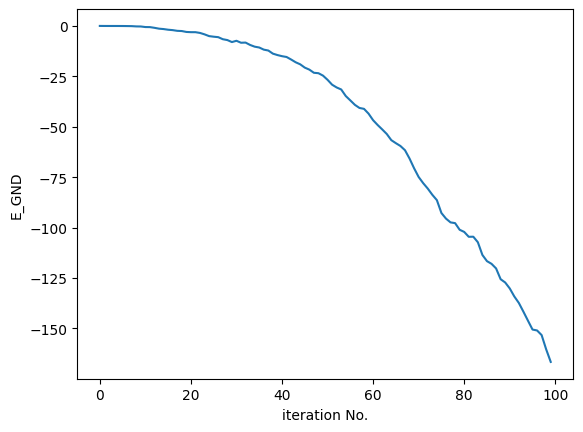

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.array(E_GND_convergence) / (np.array(range(len(E_GND_convergence))) + l))
#plt.plot(np.array(E_GND_convergence))
plt.ylabel(r"E_GND")
plt.xlabel(r"iteration No.")

In [4]:
ll.as_column_vector(np.array(range(len(E_GND_convergence))) + l).shape

(50, 1)

In [7]:
np.array(E_GND_convergence).shape

(50,)

In [17]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 10, 10, 10])
a / b

array([0.1, 0.2, 0.3, 0.4])

In [3]:
E_GND_convergence

[np.float64(-0.061217738049429996),
 np.float64(-0.06701512070961957),
 np.float64(-0.18792177157645923),
 np.float64(-0.2339199753528902),
 np.float64(-0.3135156097194775),
 np.float64(-0.38084318137768325),
 np.float64(-0.513805807179627),
 np.float64(-0.9039147582115914),
 np.float64(-1.35479343353499),
 np.float64(-2.3315349664746203),
 np.float64(-3.9117579111525567),
 np.float64(-6.579193241432619),
 np.float64(-8.64397654277863),
 np.float64(-11.65618606046772),
 np.float64(-15.521737550478361),
 np.float64(-19.895344853599536),
 np.float64(-26.59196415075088),
 np.float64(-30.184121586063203),
 np.float64(-36.35139104135806),
 np.float64(-47.44415481283266),
 np.float64(-51.797099816020875),
 np.float64(-74.1875211160122),
 np.float64(-74.67549987531281),
 np.float64(-82.81235022862033),
 np.float64(-111.82182766336172),
 np.float64(-132.23486979047104),
 np.float64(-144.34381824448485),
 np.float64(-184.56264396502715),
 np.float64(-222.0307689090234),
 np.float64(-241.4908660

In [13]:
(np.array(E_GND_convergence)[:]).shape

(50, 1)

In [16]:
ll.as_column_vector(np.array(E_GND_convergence)) / (np.array(range(len(E_GND_convergence))) + l)

array([[-1.53044345e-02, -1.22435476e-02, -1.02029563e-02, ...,
        -1.20034780e-03, -1.17726419e-03, -1.15505166e-03],
       [-1.67537802e-02, -1.34030241e-02, -1.11691868e-02, ...,
        -1.31402197e-03, -1.28875232e-03, -1.26443624e-03],
       [-4.69804429e-02, -3.75843543e-02, -3.13202953e-02, ...,
        -3.68474062e-03, -3.61388022e-03, -3.54569380e-03],
       ...,
       [-3.20167219e+02, -2.56133775e+02, -2.13444813e+02, ...,
        -2.51111544e+01, -2.46282476e+01, -2.41635637e+01],
       [-3.42883666e+02, -2.74306933e+02, -2.28589110e+02, ...,
        -2.68928365e+01, -2.63756666e+01, -2.58780125e+01],
       [-3.72050217e+02, -2.97640173e+02, -2.48033478e+02, ...,
        -2.91804092e+01, -2.86192474e+01, -2.80792616e+01]],
      shape=(50, 50))

In [9]:
T

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 21539 stored elements and shape (256, 100)>

In [4]:
H_S

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 116797 stored elements and shape (400, 400)>

In [5]:
H_S.eliminate_zeros()

In [6]:
H_S

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 116797 stored elements and shape (400, 400)>

In [3]:
eye_T_

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 400 stored elements and shape (400, 400)>

In [8]:
parity_T_

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 39208 stored elements and shape (400, 400)>

In [7]:
parity_T_.eliminate_zeros()

In [7]:
a_S = kron(parity_T, [g.a[s][0] for s in range(2)])

Exception: Unsupported types for kron

In [10]:
T

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 21539 stored elements and shape (256, 100)>

In [11]:
T_dag

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 21539 stored elements and shape (100, 256)>

In [9]:
f.parity

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 256 stored elements and shape (256, 256)>

In [8]:
parity_T

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 9802 stored elements and shape (100, 100)>

In [3]:
a_T_ = kron(a_T, g.eye)

Exception: Unsupported types for kron

In [4]:
g.eye

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (4, 4)>

In [5]:
a_T

[array([[-5.53213328e-18+0.j,  5.63835956e-18+0.j,  1.31505284e-17+0.j,
         ..., -2.48265053e-09+0.j, -4.33333432e-09+0.j,
         -1.45791600e-08+0.j],
        [ 5.13613778e-01+0.j,  6.25612326e-16+0.j,  1.58979287e-13+0.j,
         ...,  1.75940207e-06+0.j, -3.45751545e-06+0.j,
          8.36257890e-06+0.j],
        [-1.96601364e-03+0.j,  8.99932045e-17+0.j, -5.90317161e-16+0.j,
         ..., -2.36680590e-05+0.j, -1.82980949e-05+0.j,
         -8.55664372e-06+0.j],
        ...,
        [-2.87613855e-09+0.j, -7.72047188e-07+0.j, -8.78948754e-05+0.j,
         ..., -1.04299613e-02+0.j,  2.17782286e-02+0.j,
         -7.20550004e-02+0.j],
        [-5.66488830e-08+0.j, -2.16150237e-07+0.j, -4.58175553e-05+0.j,
         ..., -2.72613784e-02+0.j,  5.40979269e-02+0.j,
         -9.15065830e-02+0.j],
        [ 2.30361961e-08+0.j,  1.65705939e-07+0.j, -1.08476565e-05+0.j,
         ...,  1.58975803e-03+0.j, -1.92734273e-02+0.j,
          7.93118654e-03+0.j]]),
 array([[-1.06689230e-17+0.j,  

In [2]:
kron(parity_T, [g.a[s][0] for s in range(2)])

[<Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 19604 stored elements and shape (400, 400)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 19604 stored elements and shape (400, 400)>]

In [19]:
print(type(parity_T))

<class 'numpy.ndarray'>


In [25]:
import scipy
import numpy

In [26]:
def is_sparse_matrix(a):
    if isinstance(a, scipy.sparse.csc_matrix):
        return True
    if isinstance(a, numpy.ndarray) and a.ndim == 2:
        return True

In [27]:
is_sparse_matrix(parity_T)

True

In [17]:
parity_T

array([[ 1.00000000e+00+0.j,  1.02565360e-17+0.j, -5.15329956e-17+0.j,
        ...,  3.46944695e-18+0.j, -8.67361738e-19+0.j,
        -4.33680869e-18+0.j],
       [ 1.02565360e-17+0.j, -1.00000000e+00+0.j,  1.52330405e-17+0.j,
        ...,  5.26254371e-17+0.j,  9.46401767e-17+0.j,
        -1.24024952e-17+0.j],
       [-5.15329956e-17+0.j,  1.52330405e-17+0.j, -1.00000000e+00+0.j,
        ..., -5.46388830e-16+0.j, -4.40976505e-17+0.j,
         2.79783261e-17+0.j],
       ...,
       [ 3.46944695e-18+0.j,  5.26254371e-17+0.j, -5.46388830e-16+0.j,
        ..., -4.22686088e-01+0.j,  3.86737198e-01+0.j,
         4.28768176e-02+0.j],
       [-8.67361738e-19+0.j,  9.46401767e-17+0.j, -4.40976505e-17+0.j,
        ...,  3.86737198e-01+0.j, -2.14610628e-01+0.j,
         1.05354078e-01+0.j],
       [-4.33680869e-18+0.j, -1.24024952e-17+0.j,  2.79783261e-17+0.j,
        ...,  4.28768176e-02+0.j,  1.05354078e-01+0.j,
        -6.65462964e-01+0.j]])

In [18]:
[g.a[s][0] for s in range(2)]

[<Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2 stored elements and shape (4, 4)>,
 <Compressed Sparse Column sparse matrix of dtype 'complex128'
 	with 2 stored elements and shape (4, 4)>]

In [2]:
import numpy as np

In [16]:
psi = np.zeros(f.fermions.states.dimension ** 4, dtype = complex)
psi[:] = 1.0 


In [11]:
f.fermions.states.dimension ** 4

65536

In [9]:
H_SE

<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 648799 stored elements and shape (65536, 65536)>

In [21]:
import math

In [23]:
for i in range(100):
    psi = H_SE @ psi
    psi = psi / math.sqrt(np.vdot(psi, psi).real)

In [7]:
from scipy.sparse.linalg import eigsh
E_GND, Psi_GND = eigsh(H_SE, k=1, which='SM')

KeyboardInterrupt: 

In [ ]:
import lightcones.linalg as la
from lightcones.linalg import kron

U = 1
t = 0.05

#eps_cut = 0.00001

num_iterations = 100

m = 100
l = 5 + 1

# iteration 0: preparatory

# left subsystem

f = spinfull_fermions(l)

H_hopp = sum([sum([- t * (f.a_dag[s][i] @ f.a[s][i - 1] + f.a_dag[s][i - 1] @ f.a[s][i]) for s in range(2)]) for i in range(l)])
H_S = H_hopp + sum([U * f.n[0][i] @ f.n[1][i] for i in range(l)])

H_S_ = kron(H, f.eye)

a_S = f.a[:][-1]
a_S_dag = f.a_dag[:][-1]

a_S_ = kron(a_S, f.eye)
a_S_dag_ = kron(a_S_dag, f.eye)

# right subsystem

# fermion Hamiltonian is always even
H_E_ = kron(f.eye, H_S)

# a and a_dag are odd operators
a_E_ = kron(f.parity, a_S)
a_E_dag_ = kron(f.parity, a_S_dag)

# joint system Hamiltonian

H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])

# now start regular iterations

for i in range(num_iterations):

    # find ground state
    
    from scipy.sparse.linalg import eigsh
    E_GND, Psi_GND = eigsh(H_SE, k=1, which='SM')

    # partial trace

    r = reduce_bipartite(f.states.dimension, f.state_dimension, trace_over = 'R')

    rho = r(Psi_GND)

    # find eigenvalues sorted in ascending order

    pi, T = la.find_eigs_descending(rho)

    # keep only m largest eigenstates
    # columns are eigenstates
    T = T[:, : m] 

    # switch to the frame of revelant eigenstates
    T_dag = T.conj().T
    H_T = T_dag @ H_S @ T

    a_T = [T_dag @ a_S[s] @ T for s in range(2)]
    a_T_dag = [T_dag @ a_S_dag[s] @ T for s in range(2)]

    # new parity operator
    parity_T = T_dag @ f.parity @ T
    eye_T = la.eye(m)
    
    # add new site
    
    g = spinfull_fermions(1)
    
    # a and a_dag are odd operators
    a_S = kron(parity_T, g.a)
    a_S_dag = kron(parity_T, g.a_dag)
    
    a_T_ = kron(a_T, g.eye)
    a_T_dag_ = kron(a_T_dag, g.eye)
    
    # n is even operator
    n_ = kron(eye_T, g.n[:, 0])
        
    H_S = H_T - t * sum([a_S_dag[s] @ a_T_[s] + a_T_dag_[s] @ a_S[s] for s in range(2)]) + U * n_[0] @ n_[1]
    
    eye_T_ = kron(eye_T, g.eye)
    
    # left subsystem
    
    H_S_ = kron(H_S, eye_T_)
    
    a_S_ = kron(a_S, eye_T_)
    a_S_dag_ = kron(a_S_dag, eye_T_)

    # right subsystem

    parity_T_ = kron(parity_T, g.parity)

    # fermion Hamiltonian is always even
    H_E_ = kron(eye_T_, H_S)

    # a and a_dag are odd operators
    a_E_ = kron(parity_T_, a_S)
    a_E_dag_ = kron(parity_T_, a_S_dag)
    
    # joint system Hamiltonian

    H_SE = H_S_ + H_E_ - sum([t * (a_E_dag_[s] @ a_S_[s] + a_S_dag_[s] @ a_E_[s]) for s in range(2)])


    
    
    
    







In [ ]:
f = spinfull_fermions(n_modes)

f.states.state_at()
f.states.index_of()

f.vac()

f.up.a[i]
f.up.a_dag[i]

f.down.a[i]
f.down.a_dag[i]

f.a[s,i] # s = 0 (up) 1 (down)
f.a_dag[s, i]

f.n[s, i]

f.parity

f.zero

f.eye

In [ ]:
import numpy as np

array = np.empty((3, 3), dtype=object)
array[0, 0] = Node(...)